In [81]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [18]:
from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

mutation_rates = {
    "size": 0,
    "speed": 1,
    "vision": 0,
    "aggression": 0
}

days_log = []
for i in tqdm(range(1)):
    main_simulator = MainSimulator()
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    days_log.append(days_survived)
    print(days_survived)


# for log_item in log:
#     print(log_item)
print(log[-1])

  0%|                                                                                                                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 5082
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 4112
F

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.01s/it]

Food generation likelihood: 0.5173826949312774
Food generation likelihood: 0.5268147482648545
Food generation likelihood: 0.5367102087090513
Food generation likelihood: 0.5470753380377172
Food generation likelihood: 0.5579161197505161
Day number: 840
Population: 3
Food generation likelihood: 0.5692381823285757
Food generation likelihood: 0.5810467175108818
Food generation likelihood: 0.59334639359262
Food generation likelihood: 0.6061412637969676
Food generation likelihood: 0.6194346698286505
Food generation likelihood: 0.6332291407809653
Food generation likelihood: 0.6475262876379346
Food generation likelihood: 0.6623266936897164
Food generation likelihood: 0.6776298012619445
Food generation likelihood: 0.6934337952482357
Day number: 850
Population: 2
850
LogItem(day=850, num_species_alive=0, temperature=22.42227528729705, probability_of_food=0.6934337952482357, traits_dict={'size': [5.0, 5.0, 5.0, 5.0], 'speed': [2.8039757390762237, 2.7696982885553516, 2.671961333705235, 2.5622960475

In [4]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [5]:
def plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis):
    axis.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
    axis.plot(x_plot, (nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)), "purple", label="NLCB")
    axis.plot(x_plot, (pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)), "darkorange", label="PI")
    
    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [ ]:
x_plot = np.linspace(0, 10, 1000)[:, None]
X = np.array([[0],[5], [10]])
Y = np.array([[0]])
for x in X:
    Y = np.append(Y_init,target_speed_function(x),axis=0)
Y = Y[1:]

speed_model = GPRegression(X, Y, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
emukit_speed_model = GPyModelWrapper(speed_model)

ei_acquisition = ExpectedImprovement(emukit_speed_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_speed_model)
pi_acquisition = ProbabilityOfImprovement(emukit_speed_model)

In [ ]:

mu_plot, var_plot = emukit_speed_model.predict(x_plot)
plot_prediction(X,Y,x_plot,mu_plot,var_plot,plt)
plt.show()

In [ ]:
iterations = 20
figure, axis = plt.subplots(iterations, 2, figsize=(10, iterations*3))

for i in tqdm(range(iterations)):
    mu_plot, var_plot = emukit_speed_model.predict(x_plot)
    plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis[i,0])
    
    ei_plot = ei_acquisition.evaluate(x_plot)
    nlcb_plot = nlcb_acquisition.evaluate(x_plot)
    pi_plot = pi_acquisition.evaluate(x_plot)
    
    optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 10)]))
    x_new, _ = optimizer.optimize(nlcb_acquisition)
    print("Next position to query:", x_new)
    plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis[i,1])
    
    y_new = target_speed_function(x_new)
    X = np.append(X, x_new, axis=0)
    Y = np.append(Y, y_new, axis=0)
    emukit_speed_model.set_data(X, Y)

plt.show()

In [4]:
X_train = np.array([np.array([110,200,200,400]),np.array([300,252,300,400])])
Y_train = np.array([[100],[200]])

In [13]:
# DGP using deepgp library
Q = 5
num_layers = 1
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.Bias(X_train.shape[1])
num_inducing = 4 # Number of inducing points to use for sparsification
back_constraint = False # Whether to use back-constraint for variational posterior
encoder_dims=[[300],[150]] # Dimensions of the MLP back-constraint if set to true

dgp_model = deepgp.DeepGP([X_train.shape[1], num_layers, Y_train.shape[1]], X_train, Y_train, kernels=[kern2,None], num_inducing=num_inducing, back_constraint=back_constraint, encoder_dims=encoder_dims)

for i in range(len(dgp_model.layers)):
    output_var = dgp_model.layers[i].Y.var() if i==0 else dgp_model.layers[i].Y.mean.var()
    dgp_model.layers[i].Gaussian_noise.variance = output_var*0.01
    dgp_model.layers[i].Gaussian_noise.variance.fix()

dgp_model.optimize(max_iters=800, messages=True)
for i in range(len(dgp_model.layers)):
    dgp_model.layers[i].Gaussian_noise.variance.unfix()
dgp_model.optimize(max_iters=1200, messages=True)

  latent_space.  |   value  |  constraints  |  priors
  mean           |  (2, 1)  |               |        
  variance       |  (2, 1)  |      +ve      |         1 1
[[110 200 200 400]
 [300 252 300 400]] 4 4


In [14]:
display(dgp_model)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(4, 1)",,
obslayer.sum.rbf.variance,9108.78661789169,+ve,
obslayer.sum.rbf.lengthscale,127.98052888600307,+ve,
obslayer.sum.bias.variance,11327.789851930656,+ve,
obslayer.Gaussian_noise.variance,25.0,+ve,
obslayer.Kuu_var,"(4,)",+ve,
obslayer.latent space.mean,"(2, 1)",,
obslayer.latent space.variance,"(2, 1)",+ve,
layer_1.inducing inputs,"(4, 4)",,
layer_1.rbf.variance,4139.84455596258,+ve,


In [25]:
x_plot = np.linspace(0, 1000, 1000)[:, None]
x_new = np.stack((x_plot,x_plot,x_plot,x_plot),axis = -1)
Y_pred = dgp_model.predict(np.array([[10,10,10,10]]))

In [6]:
def target_size_function(x):
    mutation_rates = {
        "size": x,
        "speed": 0,
        "vision": 0,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived
    
def target_speed_function(x):
    mutation_rates = {
        "size": 0,
        "speed": x,
        "vision": 0,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_vision_function(x):
    mutation_rates = {
        "size": 0,
        "speed": 0,
        "vision": x,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_aggression_function(x):
    mutation_rates = {
        "size": 0,
        "speed": 0,
        "vision": 0,
        "aggression": x
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_function(X):
    mutation_rates = {
        "size": X[0],
        "speed": X[1],
        "vision": X[2],
        "aggression": X[3]
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

In [19]:
x_plot = np.linspace(0, 20, 1000)[:, None]

X_size = np.array([0,1,20])
X_speed = np.array([0,1,20])
X_vision = np.array([0,1,20])
X_aggression = np.array([0,1,20])

In [20]:
Y_size = np.array([])
for x in X_size:
    Y_size = np.append(Y_size,[target_size_function(x)],axis=0)

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 17407
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 17339

In [25]:
Y_aggression

array([258., 270., 270.])

In [22]:
Y_speed = np.array([])
for x in X_speed:
    Y_speed = np.append(Y_speed,[target_speed_function(x)],axis=0)

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 16000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 16000

In [23]:
Y_vision = np.array([])
for x in X_vision:
    Y_vision = np.append(Y_vision,[target_vision_function(x)],axis=0)

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 16000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 16000

 /Users/zoeytxc/L48/L48-Group-Project/src/species.py:113: RuntimeWarning:overflow encountered in exp


Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2348
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 2733
Food generation likelihood: 1.1886204529224607
Food generation likelihood: 1.1665995084883558
Food generation likelihood: 1.144386092115148
Food generation likelihood: 1.12203781456316
Food generation likelihood: 1.099610149021266
Food generation likelihood: 1.0771562638590373
Food generation likelihood: 1.0547268820419253
Food generation likelihood: 1.0323701667136898
Food generation likelihood: 1.0101316321954499
Foo

In [24]:
Y_aggression = np.array([])
for x in X_aggression:
    Y_aggression = np.append(Y_aggression,[target_aggression_function(x)],axis=0)

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 16000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 16000

In [8]:
size_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
speed_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
vision_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
aggression_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)

emukit_size_model = GPyModelWrapper(size_model)
emukit_speed_model = GPyModelWrapper(speed_model)
emukit_vision_model = GPyModelWrapper(vision_model)
emukit_aggression_model = GPyModelWrapper(agression_model)

size_ei_acquisition = ExpectedImprovement(emukit_size_model)
size_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_size_model)
size_pi_acquisition = ProbabilityOfImprovement(emukit_size_model)

speed_ei_acquisition = ExpectedImprovement(emukit_speed_model)
speed_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_speed_model)
speed_pi_acquisition = ProbabilityOfImprovement(emukit_speed_model)

vision_ei_acquisition = ExpectedImprovement(emukit_vision_model)
vision_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_vision_model)
vision_pi_acquisition = ProbabilityOfImprovement(emukit_vision_model)

aggression_ei_acquisition = ExpectedImprovement(emukit_aggression_model)
aggression_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_aggression_model)
aggression_pi_acquisition = ProbabilityOfImprovement(emukit_aggression_model)

NameError: name 'X_size' is not defined

In [ ]:
X_train = np.array([[1,1,1,1, Y_size[1], Y_speed[1], Y_vision[1], Y_aggression[1]],
                   [1,0,0,0, Y_size[1], Y_speed[0], Y_vision[0], Y_aggression[0]],
                   [0,1,0,0, Y_size[0], Y_speed[1], Y_vision[0], Y_aggression[0]],
                   [0,0,1,0, Y_size[0], Y_speed[0], Y_vision[1], Y_aggression[0]],
                   [0,0,0,1, Y_size[0], Y_speed[0], Y_vision[0], Y_aggression[1]]])
Y_train = np.array([[target_function([1,1,1,1])],[Y_size[1]],[Y_speed[1]],[Y_vision[1]],[Y_aggression[1]]])
Q = 5
num_layers = 1
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.Bias(X_train.shape[1])
num_inducing = 4 # Number of inducing points to use for sparsification
back_constraint = False # Whether to use back-constraint for variational posterior
encoder_dims=[[300],[150]] # Dimensions of the MLP back-constraint if set to true

In [31]:
def upper_confidence_bound(y_pred, y_std, beta):
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0

  0%|                                                                                                                                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]


NameError: name 'emukit_speed_model' is not defined

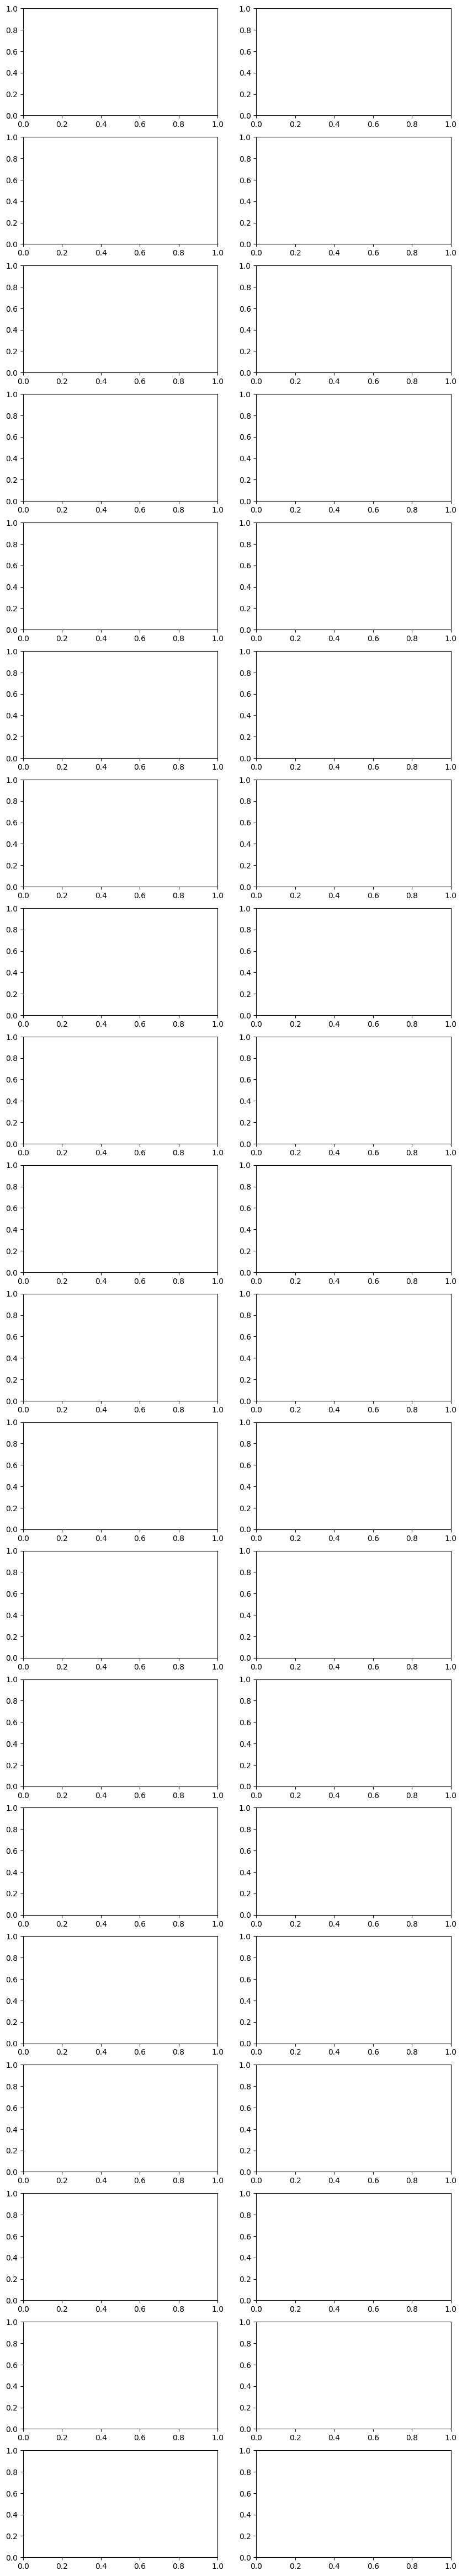

In [3]:
iterations = 20
figure, axis = plt.subplots(iterations, 2, figsize=(10, iterations*3))

for i in tqdm(range(iterations)):
    mu_speed_plot, var_speed_plot = emukit_speed_model.predict(x_plot)
    ei_speed_plot = speed_ei_acquisition.evaluate(x_plot)
    nlcb_speed_plot = speed_nlcb_acquisition.evaluate(x_plot)
    pi_speed_plot = speed_pi_acquisition.evaluate(x_plot)
    
    size_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_size_new, _ = size_optimizer.optimize(size_nlcb_acquisition)
    speed_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_speed_new, _ = speed_optimizer.optimize(speed_nlcb_acquisition)
    vision_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_vision_new, _ = vision_optimizer.optimize(vision_nlcb_acquisition)
    aggression_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_aggression_new, _ = aggression_optimizer.optimize(agression_nlcb_acquisition)

    print("Next position to query:", x_size_new, x_speed_new, x_vision_new, x_agression_new)
    
    y_size_new = target_size_function(x_size_new)
    X_size = np.append(X_size, x_size_new, axis=0)
    Y_size = np.append(Y_size, y_size_new, axis=0)
    emukit_size_model.set_data(X_size, Y_size)
    X_train = np.append(X_train,[[x_size_new,0,0,0,y_size_new, Y_speed[0], Y_vision[0], Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_size_new]])

    y_speed_new = target_speed_function(x_speed_new)
    X_speed = np.append(X_speed, x_speed_new, axis=0)
    Y_speed = np.append(Y_speed, y_speed_new, axis=0)
    emukit_speed_model.set_data(X_speed, Y_speed)
    X_train = np.append(X_train,[[0,x_speed_new,0,0,Y_size[0], y_speed_new, Y_vision[0], Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_speed_new]])

    y_vision_new = target_vision_function(x_vision_new)
    X_vision = np.append(X_vision, x_vision_new, axis=0)
    Y_vision = np.append(Y_vision, y_vision_new, axis=0)
    emukit_vision_model.set_data(X_vision, Y_vision)
    X_train = np.append(X_train,[[0,0,x_vision_new,0,Y_size[0], Y_speed[0], y_vision_new, Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_vision_new]])

    y_aggression_new = target_aggression_function(x_aggression_new)
    X_aggression = np.append(X_aggression, x_speed_new, axis=0)
    Y_aggression = np.append(Y_aggression, y_aggression_new, axis=0)
    emukit_aggression_model.set_data(X_aggression, Y_aggression)
    X_train = np.append(X_train,[[0,0,0,x_aggression_new,Y_size[0], Y_speed[0], Y_vision[0], y_aggression_new]], axis=0)
    Y_train = np.append(Y_train,[[y_aggression_new]])

    X_train = np.append(X_train,[[x_size_new,x_speed_new,x_vision_new,x_aggression_new,y_size_new,y_speed_new,y_vision_new,y_aggression_new]], axis=0)
    Y_train = np.append(Y_train,[[target_function([x_size_new,x_speed_new,x_vision_new,x_aggression_new])]])

    dgp_model = deepgp.DeepGP([X_train.shape[1], num_layers, Y_train.shape[1]], X_train, Y_train, kernels=[kern2,None], num_inducing=num_inducing, back_constraint=back_constraint, encoder_dims=encoder_dims)
    
    for i in range(len(dgp_model.layers)):
        output_var = dgp_model.layers[i].Y.var() if i==0 else dgp_model.layers[i].Y.mean.var()
        dgp_model.layers[i].Gaussian_noise.variance = output_var*0.01
        dgp_model.layers[i].Gaussian_noise.variance.fix()
    
    dgp_model.optimize(max_iters=800, messages=True)
    for i in range(len(dgp_model.layers)):
        dgp_model.layers[i].Gaussian_noise.variance.unfix()
    dgp_model.optimize(max_iters=1200, messages=True)

In [ ]:
x_plot = np.linspace(0, 10, 1000)[:, None]
X = np.array([[0],[5], [10]])
Y = np.array([[0]])
for x in X:
    Y = np.append(Y,target_speed_function(x),axis=0)
Y = Y[1:]

model = GPRegression(X, Y, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
emukit_model = GPyModelWrapper(model)

ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

In [43]:
def target_function_list(X):
    Y = np.array([[0]])
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
            period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
        Y = np.append(Y, [[days_survived]], axis = 0)
    return Y[1:]

In [56]:
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter

space = ParameterSpace([ContinuousParameter('size', 0, 20),
                        ContinuousParameter('speed', 0, 20),
                        ContinuousParameter('vision', 0, 20),
                        ContinuousParameter('aggression', 0, 20)])

design = RandomDesign(space) # Collect random points
num_data_points = 5
X = design.get_samples(num_data_points)
Y = target_function_list(X)
model_gpy = GPRegression(X,Y) # Train and wrap the model in Emukit
model_emukit = GPyModelWrapper(model_gpy)

Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food generation likelihood: 1.2103893712091416
Day number: 20
Population: 2000
F

NameError: name 'emukit_model' is not defined

In [73]:
ei_acquisition = ExpectedImprovement(model = model_emukit)
nlcb_acquisition = NegativeLowerConfidenceBound(model = model_emukit)
pi_acquisition = ProbabilityOfImprovement(model = model_emukit)

In [ ]:
iterations = 20
figure, axis = plt.subplots(iterations, 2, figsize=(10, iterations*3))
# Control along which trait is the function plotted
plot = 0
x_plot = np.linspace(0, 20, 1000)[:, None]
x_zeros = np.linspace(0, 0, 1000)[:, None]
x_linear = np.linspace(0, 20, 1000)[:, None]

for i in tqdm(range(iterations)):
    for j in range(plot):
        x_plot = np.append(x_zeros, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_zeros, axis = 1)
        
    mu_plot, var_plot = model_emukit.predict(x_plot)
    plot_prediction(X,Y,x_linear,mu_plot,var_plot,axis[i,0])
    
    ei_plot = ei_acquisition.evaluate(x_plot)
    nlcb_plot = nlcb_acquisition.evaluate(x_plot)
    pi_plot = pi_acquisition.evaluate(x_plot)
    
    optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('size', 0, 20),
                                                             ContinuousParameter('speed', 0, 20),
                                                             ContinuousParameter('vision', 0, 20),
                                                             ContinuousParameter('aggression', 0, 20)]))
    x_new, _ = optimizer.optimize(nlcb_acquisition)
    #print(x_new[0][plot])
    plot_acquisition_functions(x_linear, ei_plot, nlcb_plot, pi_plot, x_new[0][plot], axis[i,1])
    #print(x_new)
    print("Next position to query:", x_new)
    # plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis[i,1])
    
    y_new = target_function_list(x_new)
    X = np.append(X, x_new, axis=0)
    Y = np.append(Y, y_new, axis=0)
    model_emukit.set_data(X, Y)

plt.show()

  0%|                                                                                                                                                                                                                                                                                                | 0/20 [00:00<?, ?it/s] /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_60413/82289318.py:4: RuntimeWarning:invalid value encountered in divide


Next position to query: [[2.00148561 9.45366385 9.76326873 8.84873728]]
Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
Food generation likelihood: 1.2936987798040507
Food generation likelihood: 1.273564098011204
Food generation likelihood: 1.2529245470328825
Food generation likelihood: 1.2318449865946015
Food gen

  5%|██████████████                                                                                                                                                                                                                                                                          | 1/20 [00:05<01:47,  5.63s/it]

Food generation likelihood: 0.21245750222251222
Food generation likelihood: 0.21056834395206925
Food generation likelihood: 0.20891080721028749
Food generation likelihood: 0.20748146779120602
Food generation likelihood: 0.20627736038379207
Day number: 260
Population: 5
Food generation likelihood: 0.20529597802649055
Food generation likelihood: 0.20453527151758266
Food generation likelihood: 0.20399364884641447
Food generation likelihood: 0.20366997469828646
Food generation likelihood: 0.20356357007376616
Food generation likelihood: 0.20367421205136016
Food generation likelihood: 0.20400213371081188
Food generation likelihood: 0.20454802422269744
Food generation likelihood: 0.20531302909843946
Next position to query: [[ 0.51287274 19.55398327 13.79297712  3.65928271]]
Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.46345

 10%|████████████████████████████                                                                                                                                                                                                                                                            | 2/20 [00:12<01:54,  6.34s/it]

Food generation likelihood: 0.20400213371081188
Food generation likelihood: 0.20454802422269744
Food generation likelihood: 0.20531302909843946
Food generation likelihood: 0.20629875058327077
Day number: 270
Population: 1
Food generation likelihood: 0.20750724816299676
Food generation likelihood: 0.208941039143577
Next position to query: [[19.45771778 17.65276594  5.11619108  0.71816031]]
Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation

 15%|██████████████████████████████████████████                                                                                                                                                                                                                                              | 3/20 [00:19<01:50,  6.53s/it]

Food generation likelihood: 0.21249686318275618
Food generation likelihood: 0.21462622504321216
Food generation likelihood: 0.21699553855511805
Food generation likelihood: 0.2196096169601578
Food generation likelihood: 0.2224737324806614
Next position to query: [[13.08550825 18.78459646  0.44832229 19.81935324]]
Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219


 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 4/20 [00:25<01:42,  6.43s/it]

Food generation likelihood: 0.20529597802649055
Food generation likelihood: 0.20453527151758266
Food generation likelihood: 0.20399364884641447
Food generation likelihood: 0.20366997469828646
Food generation likelihood: 0.20356357007376616
Food generation likelihood: 0.20367421205136016
Food generation likelihood: 0.20400213371081188
Food generation likelihood: 0.20454802422269744
Food generation likelihood: 0.20531302909843946
Food generation likelihood: 0.20629875058327077
Day number: 270
Population: 3
Food generation likelihood: 0.20750724816299676
Food generation likelihood: 0.208941039143577
Food generation likelihood: 0.21060309925051518
Food generation likelihood: 0.21249686318275618
Food generation likelihood: 0.21462622504321216
Food generation likelihood: 0.21699553855511805
Food generation likelihood: 0.2196096169601578
Food generation likelihood: 0.2224737324806614
Food generation likelihood: 0.22559361521416818
Next position to query: [[11.13310777  7.24257997  0.06170565 

 25%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 5/20 [00:33<01:46,  7.07s/it]

Food generation likelihood: 0.24076131808685414
Food generation likelihood: 0.24526183263627335
Food generation likelihood: 0.2500619370238206
Food generation likelihood: 0.2551704534280952
Next position to query: [[19.67917453 10.1535413   8.06652218 10.76504584]]
Food generation likelihood: 1.4924141613183488
Food generation likelihood: 1.4871438652232216
Food generation likelihood: 1.480536940538561
Food generation likelihood: 1.4726271151301735
Food generation likelihood: 1.463452784586378
Food generation likelihood: 1.4530567041876021
Food generation likelihood: 1.4414856540816547
Food generation likelihood: 1.4287900816800168
Food generation likelihood: 1.4150237254544173
Food generation likelihood: 1.4002432244099798
Day number: 10
Population: 2000
Food generation likelihood: 1.3845077175420295
Food generation likelihood: 1.367878437550251
Food generation likelihood: 1.3504183029894732
Food generation likelihood: 1.332191512885219
Food generation likelihood: 1.3132631476394918
F